# Investment Game
The rules of the investment game are outlined in the `README.md`. Here we are implementing a simple environment in order to play the game.

In [8]:
import numpy as np
import gym

## Time-series for assets

In [9]:
import seaborn as sns
import pandas as pd
from scipy import interpolate
import matplotlib.pyplot as plt
sns.set()

/home/malte/anaconda3/envs/rl-invest/lib/python3.8/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/malte/anaconda3/envs/rl-invest/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/malte/anaconda3/envs/rl-invest/lib/python3.8/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/malte/anaconda3/envs/rl-invest/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [128]:
# parameter
std_dev_noise = 0.1
x_max = 100
y_min, y_max = [1, 5]
num_nodes = 5
x_range = np.arange(1, x_max-1)
values = np.arange(y_min, y_max)

In [135]:
x = np.sort(np.append(np.random.choice(x_range, num_nodes, replace=False), np.array([0, x_max-1])))
y = np.random.choice(values, num_nodes+2, replace=True)
f = interpolate.interp1d(x, y, kind='linear', bounds_error=False)

x_interpolated = np.arange(x_max)
noise = np.random.normal(0, std_dev_noise, len(x_interpolated))
signal = f(x_interpolated) + noise
df = pd.DataFrame({'round': x_interpolated, 'price': signal})


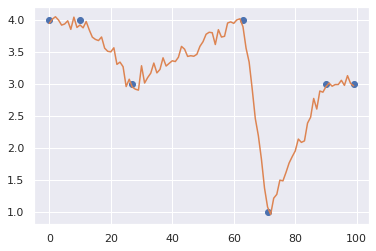

In [136]:
plt.plot(x, y, 'o', x_interpolated, signal, '-')

<AxesSubplot:xlabel='round', ylabel='price'>

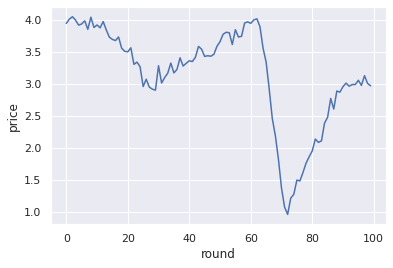

In [137]:
sns.lineplot(data=df, x='round', y='price')

In [138]:
# save asset price to disk
import os
prefix = 'resources/data/'
os.makedirs(prefix, exist_ok=True)
file_name = os.path.join(prefix, 'asset.csv')
df.to_csv(file_name, index=False)

## Game environment

In [139]:
class InvestmentGame(gym.Env):
    def __init__(self):
        self.num_rounds = 100
        self.initial_balance = 100
        self.state = self.reset() # round balance portfolio
        self.asset = pd.read_csv(file_name)
        self.action_space = [0, 1, 2, 3, 4, 5]
        # state space is way to compicated 
        
    def is_terminal(self, state):
        round = state['round']
        if round >= self.num_rounds:
            return True
        else:
            return False
        
    def reset(self):
        self.round = 0
        self.balance = self.initial_balance
        self.portfolio = {'amount': 0, 'price': 0}
        return (self.round, self.balance, self.portfolio)
    
    def step(self, action):
        # get current price for asset_a
        round, balance, portfolio = self.state
        price_per_stock = df.query('round == @round')['price'].values[0]
        if action['option'] == 'buy':
            price = price_per_stock * action['amount']
            if price <= balance:
                portfolio['amount'] += action['amount']
                balance -= price
            else:
                print('Balance not sufficient for transaction.')
        # update portfolio
        portfolio['price'] = price_per_stock * portfolio['amount']
        round += 1 
        self.state = (round, balance, portfolio)


In [142]:
investmentGame = InvestmentGame()

In [179]:
action = {'option': 'buy', 'amount': 5}
investmentGame.step(action=action)
print(investmentGame.state)

Balance not sufficient for transaction.
(37, 0.29985191177781445, {'amount': 25, 'price': 80.69522378535976})
